In [38]:
# Import libraries
import torch as th
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.auto import trange
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [39]:
# Import datasets

sep_data = th.load('../datasets/sep_states.pt')

ent_data = th.load('../datasets/ent_states.pt')

sep_data_pair = th.stack((sep_data.real, sep_data.imag), dim=-1)
ent_data_pair = th.stack((ent_data.real, ent_data.imag), dim=-1)

sep_data_pair.shape, ent_data_pair.shape

(torch.Size([10000, 4, 2]), torch.Size([10000, 4, 2]))

In [40]:
# Split the data into training and testing sets

sep_train, sep_test = train_test_split(sep_data_pair, test_size=0.3)
ent_train, ent_test = train_test_split(ent_data_pair, test_size=0.3)

sep_train.shape, sep_test.shape, ent_train.shape, ent_test.shape

(torch.Size([7000, 4, 2]),
 torch.Size([3000, 4, 2]),
 torch.Size([7000, 4, 2]),
 torch.Size([3000, 4, 2]))

In [41]:
BATCH_SIZE = 64
ent_train_loader = DataLoader(ent_train, batch_size=BATCH_SIZE, shuffle=True)
ent_test_loader = DataLoader(ent_test, batch_size=BATCH_SIZE, shuffle=True)
sep_train_loader = DataLoader(sep_train, batch_size=BATCH_SIZE, shuffle=True)
sep_test_loader = DataLoader(sep_test, batch_size=BATCH_SIZE, shuffle=True)

In [42]:
## Import train and test dataset, scale them and convert them to data loaders

from torchvision import datasets, transforms

BATCH_SIZE = 64


MNIST_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform= transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0, 1)]),
    download=True
)


In [43]:
data, labels = MNIST_dataset.data, MNIST_dataset.targets

mask = labels == 6

MNIST_6 = data[mask].float()

In [44]:
train_loader = DataLoader(dataset = MNIST_6,
                          batch_size = BATCH_SIZE,
                          shuffle = True)

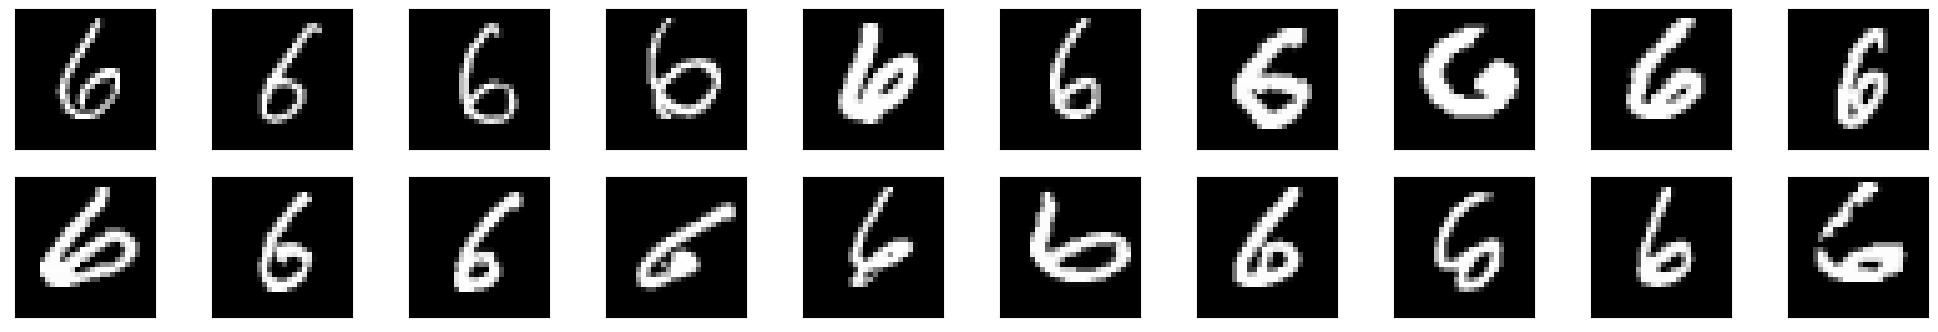

In [45]:
images = next(iter(train_loader)).numpy()

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor

In [46]:
# Define the loss function

def custom_loss(x, x_hat, mean, logvar):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5 * th.sum(1 + logvar - mean * mean - logvar.exp())
    
    return reproduction_loss + KLD

In [47]:
class VAE_fc(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(VAE_fc, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        
        self.leaky_relu = nn.LeakyReLU(0.2)
        
        self.fc3 = nn.Linear(hidden_size[1], hidden_size[0])
        self.fc4 = nn.Linear(hidden_size[0], input_size)
    
    def encode(self, x):
        
        # print("flatten", x.shape)
        x = self.fc1(x)
        x = self.leaky_relu(x)
        # print("fc1", x.shape)
        
        x = self.fc2(x)
        x = self.leaky_relu(x)
        # print("fc2", x.shape)
        return x
    
    def decode(self, x):
        x = self.fc3(x)
        x = self.leaky_relu(x)
        
        x = self.fc4(x)
        x = self.leaky_relu(x)
        return nn.Sigmoid()(x)
    
    def forward(self, x):
        # print("input", x.shape)
        x = x.flatten(start_dim=1)
        # print("flatten", x.shape)
        encoded = self.encode(x)
        
        decoded = self.decode(encoded)
        return encoded, decoded

In [68]:
def get_batch_accuracy(logit, target):
    corrects = (th.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()


def get_test_stats(model, criterion, test_loader, device):
    test_acc, test_loss = 0.0, 0.0
    for _, data in enumerate(test_loader):
        data = data.to(device)
        _, decoded = model(data)
        test_loss += criterion(data, decoded).item()
        test_acc += get_batch_accuracy(data, decoded)
        return test_loss, test_acc

def train_model(model, train_loader, epochs, optimizer, criterion, device):
    _trained_model = model.to(device)
    _trained_model.train()
    _train_loss = []
    for _ in range(epochs):
        _total_loss = 0.0
        for _, _data in enumerate(train_loader):
            _data = _data.to(device)
            _, _decoded = _trained_model(_data)
            _loss = criterion(_data.flatten(start_dim=1), _decoded)
            optimizer.zero_grad()
            _loss.backward()
            optimizer.step()
            _total_loss += _loss.item() * data.size(0)
            
        _train_loss.append(_total_loss / len(train_loader.dataset))
        
        # print('Epoch: {}, Loss: {:.4f}'.format(epoch, epoch_loss))
    return _train_loss, _trained_model

In [69]:
model = VAE_fc(input_size=4 * 2, hidden_size=[32, 16])
optimizer = th.optim.Adam(model.parameters(), lr=0.01)

train_loss, model = train_model(model=model,
                    train_loader=ent_train_loader,
                    epochs=100,
                    optimizer=optimizer,
                    criterion=nn.MSELoss(),
                    device='cpu')


Text(0, 0.5, 'Loss')

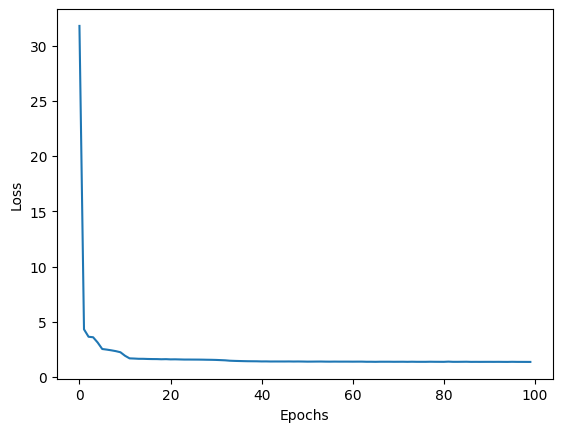

In [73]:
plt.plot(np.arange(len(train_loss)), train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [60]:
_, result = model(ent_train)

ent_data_reconsructed = result.view(-1, 4, 2)

ent_data_reconsructed

tensor([[[0.1879, 0.0036],
         [0.1625, 0.0050],
         [0.1828, 0.0020],
         [0.1570, 0.0022]],

        [[0.2033, 0.0051],
         [0.1619, 0.0068],
         [0.1834, 0.0032],
         [0.1426, 0.0032]],

        [[0.0754, 0.0009],
         [0.0770, 0.0015],
         [0.0844, 0.0006],
         [0.0908, 0.0005]],

        ...,

        [[0.0811, 0.0008],
         [0.0784, 0.0012],
         [0.0873, 0.0005],
         [0.0884, 0.0004]],

        [[0.2235, 0.0071],
         [0.3113, 0.0099],
         [0.3183, 0.0031],
         [0.4292, 0.0048]],

        [[0.1712, 0.0035],
         [0.1456, 0.0049],
         [0.1633, 0.0021],
         [0.1388, 0.0022]]], grad_fn=<ViewBackward0>)

In [51]:
model = VAE_fc(input_size=28 * 28, hidden_size=[14 * 28, 14 * 14])


model = train_model(model=model,
                    train_loader=train_loader,
                    epochs=5,
                    optimizer=optimizer,
                    criterion=nn.MSELoss(),
                    device='cpu')

Epoch: 0, Loss: 7631.4725
Epoch: 1, Loss: 7631.4725
Epoch: 2, Loss: 7631.4725
Epoch: 3, Loss: 7631.4725
Epoch: 4, Loss: 7631.4725


In [52]:
_, reconstructed_data = model(MNIST_6)

reconstructed_data = reconstructed_data.view(-1, 28, 28).detach().numpy()
reconstructed_data.shape

(5918, 28, 28)

In [53]:
next(iter(reconstructed_data))[0]

array([0.4125404 , 0.6281703 , 0.6638701 , 0.8958901 , 0.99797577,
       0.432627  , 0.4466593 , 0.4280942 , 0.42627883, 0.44609702,
       0.40483668, 0.98523456, 0.9968346 , 0.4753373 , 0.97488064,
       0.43245634, 0.5893256 , 0.96820974, 0.9987276 , 0.9218101 ,
       0.884059  , 0.38386956, 0.41969696, 0.28535873, 0.3359653 ,
       0.98916936, 0.8774677 , 0.46693674], dtype=float32)

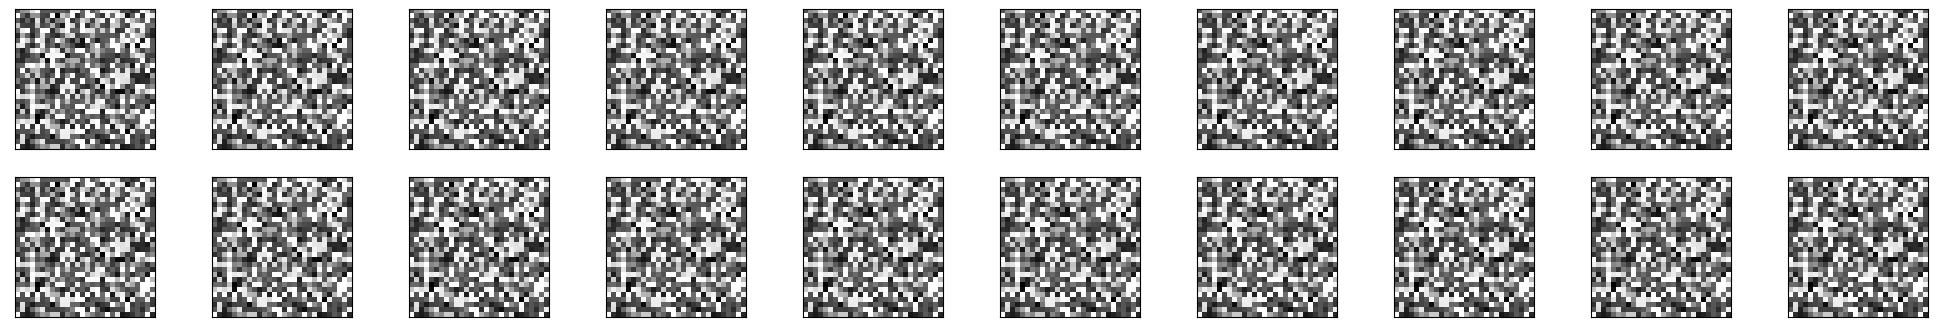

In [54]:
images = next(iter(reconstructed_data))

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor